![data cube logo](https://static.wixstatic.com/media/8959d6_a13dc7ece5be4678af57c8f7c1667734~mv2.png/v1/fill/w_279,h_177,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/VSDC_DataCubeSplash_6Partner_edited.png)
# Rasterizing vectors and vectorizing rasters

 - Sign up to the [VA Datacube](https://www.data4va.org/) to run this notebook interactively from a browser
 - <b>Compatibility</b>: Notebook currently compatible with the Virginia DataCube Sandbox environments    
 - <b>Notebook Use:</b> If you would like to modify and save this notebook, please copy and paste it into your own folder on the data cube.
 - <b>Products used</b>:
    - ESRI Landcover data set as the raster: `io_lulc`

## Background


Many geospatial workflows require converting between vector (points, lines, and polygons) and raster data (pixel-based) between each other. For example, we may need to use a shapefile as a mask to limit the analysis extent of a raster, or have raster data that we want to convert into vector data to allow for easy geometry operations.

## Description

This notebook demonstrates the use of the DEA function `xr_rasterize` and `xr_vectorize` from `deafrica_tools.spatial` tool.

1. In the first section we will use the ESRI landcover data set raster and vectorize it into a `geopandas.GeoDataFrame`. 
2. In the second section we will take our new polygon land cover and convert it back into a raster, i.e. an `xarray.DataArray`. 


---------------------------------------------------------------------------------------------------------------------------

## Getting started


To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. Begin with any iPython magic commands, followed by standard Python packages, then any additional functionality you need from the Scripts directory.

In [19]:
import datacube
import matplotlib.pyplot as plt
import sys
from matplotlib import colors as mcolours
import numpy as np
import xarray as xr
from deafrica_tools.spatial import xr_vectorize, xr_rasterize
from rasterio.transform import Affine
import rasterio
import geopandas as gpd
from descartes import PolygonPatch
from rasterio.features import shapes
from shapely.geometry import Polygon

### Connect to the datacube

Connect to the datacube so we can access DEA data. The app parameter is a unique name for the analysis which is based on the notebook file name

In [2]:
dc = datacube.Datacube(app='Rasterize_vectorize')

## Load the ESRI Landcover from the datacube

We will load Impact Observatory's [Land Use Land Cover](https://livingatlas.arcgis.com/landcover/)
   - The Land Use Land Cover Maps are a collection of land classification datasets that were generated by the Impact Observatory using Sentinel-2 products. Nine spectral bands were utilized to create nine different land classifcations of the Earth.

In [3]:
# This is a point in Norfolk,VA
lat, lon =  37, -76.5
buf = 0.8
lons = (lon - buf, lon + buf)
lats = (lat - buf, lat + buf)

# Load the data at 10 m resolution
ds = dc.load(
    product="io_lulc",
    longitude=lons,
    latitude=lats,
    resolution=(-.00027, .00027),
    output_crs="epsg:4326"
)

ds

/opt/tljh/user/lib/python3.9/site-packages/datacube/drivers/postgres/_api.py:564: SAWarning: Class Float8Range will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  return self._connection.execute(select_query)


<xarray.Dataset>
Dimensions:      (time: 1, latitude: 5926, longitude: 5927)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-02
  * latitude     (latitude) float64 37.8 37.8 37.8 37.8 ... 36.2 36.2 36.2 36.2
  * longitude    (longitude) float64 -77.3 -77.3 -77.3 ... -75.7 -75.7 -75.7
    spatial_ref  int32 4326
Data variables:
    data         (time, latitude, longitude) uint8 2 2 2 2 2 2 2 ... 1 1 1 1 1 1
Attributes:
    crs:           epsg:4326
    grid_mapping:  spatial_ref

### Plot the land cover data

Let's plot the land cover data to get an idea of what area we will be transforming. In the block below, we first give a color ramp for the different land cover classes. Then we will plot it. 

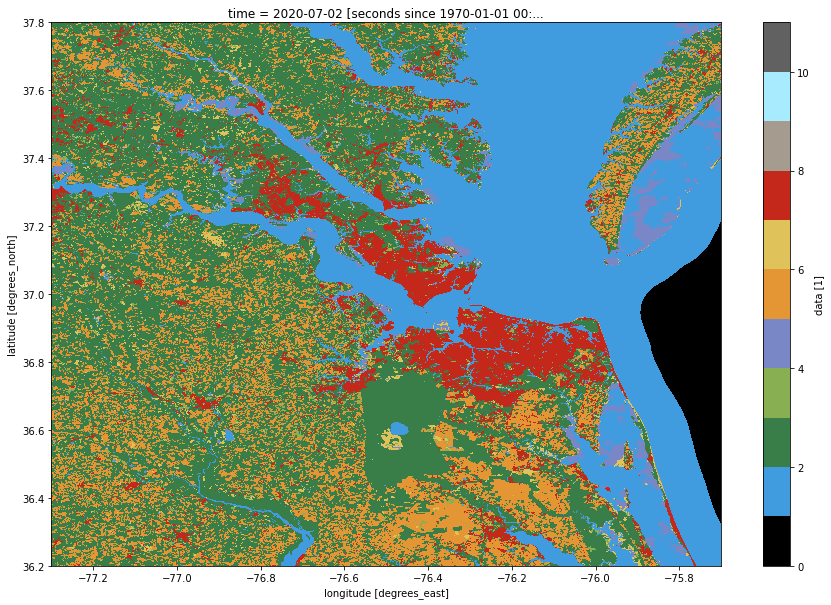

In [4]:
# Colour it like the ESRI colour map
cmap = mcolours.ListedColormap([
      np.array([0, 0, 0]) / 255,
      np.array([65, 155, 223]) / 255,
      np.array([57, 125, 73]) / 255,
      np.array([136, 176, 83]) / 255,
      np.array([122, 135, 198]) / 255,
      np.array([228, 150, 53]) / 255,
      np.array([223, 195, 90]) / 255,
      np.array([196 ,40, 27]) / 255,
      np.array([165, 155, 143]) / 255,
      np.array([168, 235, 255]) / 255,
      np.array([97, 97, 97]) / 255
])
bounds=range(0,12)
norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)
ds.isel(time=0).data.plot.imshow(cmap=cmap, norm=norm, size=10)

## Vectorizing an `xarray.DataArray`

To convert our `xarray.DataArray` object into a vector based `geopandas.GeoDataFrame`, we can use the DEA function `xr_vectorize` from [deafrica_tools.spatial](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Tools/gen/deafrica_tools.spatial.html). This tool is based on the rasterio.features.shape function, and can accept any of the arguments in [rasterio.features.shape](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html) using the same syntax.

In the cell below, we use the argument `mask=ds.values==2` to indicate we only want to convert the values in the xarray object that are equal to 2.

In [5]:
print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, latitude: 5926, longitude: 5927)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-02
  * latitude     (latitude) float64 37.8 37.8 37.8 37.8 ... 36.2 36.2 36.2 36.2
  * longitude    (longitude) float64 -77.3 -77.3 -77.3 ... -75.7 -75.7 -75.7
    spatial_ref  int32 4326
Data variables:
    data         (time, latitude, longitude) uint8 2 2 2 2 2 2 2 ... 1 1 1 1 1 1
Attributes:
    crs:           epsg:4326
    grid_mapping:  spatial_ref


Since our data is a type `xarray.Dataset`, we will need to convert it first to a `xarray.DataArray` then we can vectorize.

/opt/tljh/user/lib/python3.9/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


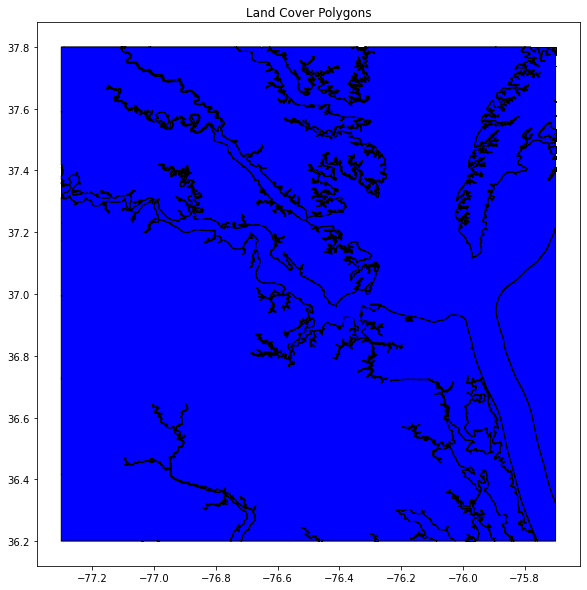

In [28]:
# Define the land cover types to mask out
mask_land_cover_types = [0, 1]  # Example list of land cover types to mask out

# Mask out the specific land cover types
masked_data = ds['data'].where(~np.isin(ds['data'], mask_land_cover_types))

# Convert masked data to a binary mask
mask = masked_data.notnull()

# Convert binary mask to a 2D NumPy array
mask_array = mask.data.squeeze().astype(np.uint8)

# Convert binary mask to polygons
shapes_generator = shapes(mask_array, transform=masked_data.geobox.transform)

polygons = []
for shape, value in shapes_generator:
    coordinates = shape['coordinates']
    polygon = Polygon(coordinates[0])
    polygons.append(polygon)

# Create GeoDataFrame from the polygons
gdf = gpd.GeoDataFrame(geometry=polygons)

# Create a larger plot figure
fig, ax = plt.subplots(figsize=(10, 10))

# Set the mask color to blue and everything else to white
gdf['color'] = 'white'
gdf.loc[gdf.intersects(gdf.loc[gdf['color'] == 'white'].unary_union), 'color'] = 'blue'
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black', legend=False)

# Add plot title and show the plot
plt.title('Land Cover Polygons')
plt.show()

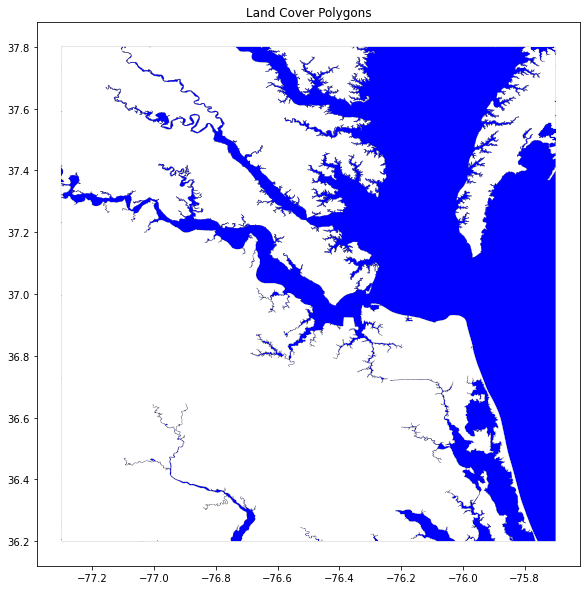

In [45]:
# Define the land cover types to mask out
mask_land_cover_types = [0, 1]  # Example list of land cover types to mask out

# Mask out the specific land cover types
masked_data = ds['data'].where(~np.isin(ds['data'], mask_land_cover_types))

# Convert masked data to a binary mask
mask = masked_data.notnull()

# Convert binary mask to a 2D NumPy array
mask_array = mask.data.squeeze().astype(np.uint8)

# Convert binary mask to polygons
shapes_generator = shapes(mask_array, transform=ds['data'].affine)

polygons = []
land_cover_types = []  # To store the land cover type for each polygon

for shape, value in shapes_generator:
    coordinates = shape['coordinates']
    polygon = Polygon(coordinates[0])
    polygons.append(polygon)
    land_cover_types.append(value)

# Create GeoDataFrame from the polygons and land cover types
gdf = gpd.GeoDataFrame({'geometry': polygons, 'land_cover': land_cover_types})

# Assign color to polygons based on land cover type
gdf['color'] = 'blue'
gdf.loc[gdf['land_cover'] == 1, 'color'] = 'white'

# Create a larger plot figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygons with assigned colors and adjust line width
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black', linewidth=0.1, legend=False)

# Add plot title and show the plot
plt.title('Land Cover Polygons')
plt.show()


In [37]:
#Convert from Dataset to DataArray
ds_da = ds.to_array()

#double check
print(ds_da)

print(ds_da.shape)

gdf = xr_vectorize(da=ds_da,
                   mask = ds_da.values == 1)

<xarray.DataArray (variable: 1, time: 1, latitude: 5926, longitude: 5927)>
array([[[[2, 2, 2, ..., 4, 4, 4],
         [2, 2, 2, ..., 4, 4, 4],
         [2, 2, 2, ..., 4, 4, 4],
         ...,
         [5, 5, 5, ..., 1, 1, 1],
         [5, 5, 5, ..., 1, 1, 1],
         [5, 5, 5, ..., 1, 1, 1]]]], dtype=uint8)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-02
  * latitude     (latitude) float64 37.8 37.8 37.8 37.8 ... 36.2 36.2 36.2 36.2
  * longitude    (longitude) float64 -77.3 -77.3 -77.3 ... -75.7 -75.7 -75.7
    spatial_ref  int32 4326
  * variable     (variable) <U4 'data'
Attributes:
    crs:           epsg:4326
    grid_mapping:  spatial_ref
(1, 1, 5926, 5927)


ValueError: height must be > 0

### Subheading 1

Use subheadings to break up steps within a single section.

In [ ]:
# Use code comments for low-level documentation of code
b = 2

## Heading 2

Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.


In [1]:
# Use code comments for low-level documentation of code
c = 3

## Additional information

<b>License:</b> The code in this notebook is licensed under the Apache License, Version 2.0. Digital Earth Australia data is licensed under the Creative Commons by Attribution 4.0 license.

<b>Contact:</b> If you need assistance, please post a question on the Open Data Cube Slack channel or on the GIS Stack Exchange using the open-data-cube tag (you can view previously asked questions here). If you would like to report an issue with this notebook, you can file one on Github.

<b>Last modified:</b> May 2020

<b>Compatible datacube version:</b>

In [ ]:
print(datacube.__version__)

## Tags 
Browse all available tags on the VA Data Cube User Guide's Tags Index 